<a href="https://colab.research.google.com/github/Karsten-Yan/ky_blood_cell_images_kaggle/blob/master/blood_cell_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#upload kaggle.json api file
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [3]:
!mkdir /root/.kaggle
!mv /content/kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/blood-cells

mkdir: cannot create directory ‘/root/.kaggle’: File exists
blood-cells.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
zip_ref = zipfile.ZipFile('blood-cells.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [5]:
train_datagen = ImageDataGenerator(
        rescale = 1./255.,
        #validation_split=0.2
    )

validation_datagen = ImageDataGenerator(
    rescale = 1.0/255.)

In [6]:
base_dir = '/content/dataset2-master/dataset2-master/images'

train_dir = os.path.join(base_dir, 'TRAIN')
validation_dir = os.path.join(base_dir, 'TEST')

# Directory with our training cat/dog pictures
train_eo_dir = os.path.join(train_dir, 'EOSINOPHIL')
train_lympho_dir = os.path.join(train_dir, 'LYMPHOCYTE')
train_mono_dir = os.path.join(train_dir, 'MONOCYTE')
train_neutro_dir = os.path.join(train_dir, 'NEUTROPHIL')

# Directory with our validation cat/dog pictures
test_eo_dir = os.path.join(validation_dir, 'EOSINOPHIL')
test_lympho_dir = os.path.join(validation_dir, 'LYMPHOCYTE')
test_mono_dir = os.path.join(validation_dir, 'MONOCYTE')
test_neutro_dir = os.path.join(validation_dir, 'NEUTROPHIL')


In [7]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150),
                                                    #subset="training"
                                                    ) 
val_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150),
                                                    subset="validation")   
validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=32,
                                                         class_mode  = 'categorical',
                                                         target_size = (150, 150))

Found 9957 images belonging to 4 classes.
Found 0 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [8]:
tf.random.set_seed(
    42
)

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer="l2"),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax') 
])

# Compile Model. 
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [11]:

# Train the Model
history = model.fit(train_generator,
                              epochs=40,
                              verbose=1,
                              validation_data=validation_generator,
                              )

Epoch 1/40
312/312 [==============================] - 26s 85ms/step - loss: 1.4361 - accuracy: 0.2588 - val_loss: 1.3942 - val_accuracy: 0.2754
Epoch 2/40
312/312 [==============================] - 26s 83ms/step - loss: 1.3352 - accuracy: 0.3661 - val_loss: 1.2303 - val_accuracy: 0.3796
Epoch 3/40
312/312 [==============================] - 26s 82ms/step - loss: 1.2393 - accuracy: 0.4458 - val_loss: 1.0817 - val_accuracy: 0.4942
Epoch 4/40
312/312 [==============================] - 26s 83ms/step - loss: 1.2132 - accuracy: 0.4681 - val_loss: 1.0715 - val_accuracy: 0.5259
Epoch 5/40
312/312 [==============================] - 26s 83ms/step - loss: 1.1229 - accuracy: 0.5193 - val_loss: 1.0267 - val_accuracy: 0.5794
Epoch 6/40
312/312 [==============================] - 26s 83ms/step - loss: 1.0559 - accuracy: 0.5644 - val_loss: 0.9918 - val_accuracy: 0.6261
Epoch 7/40
312/312 [==============================] - 26s 83ms/step - loss: 0.9649 - accuracy: 0.6145 - val_loss: 0.8652 - val_accuracy:

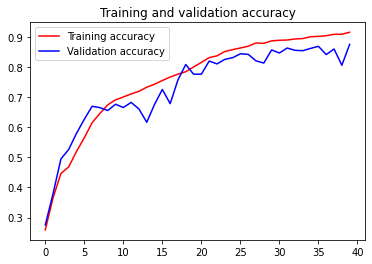

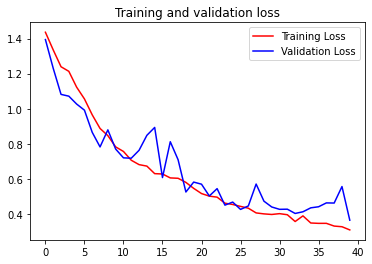

In [12]:
# Plot the chart for accuracy and loss on both training and validation

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()